# Кластеризация и снижение размерности

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.cluster import (
    KMeans,
    DBSCAN,
    AgglomerativeClustering
)
from sklearn.datasets import make_blobs, make_moons, make_circles

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from matplotlib import pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stops = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Кластеризация

### Теория

**Кластеризация** $-$ одна из классических задач обучения без учителя, в рамках которой требуется разбить множество объектов на группы по "похожести" так, чтобы объекты внутри группы были как можно более похожи, а группы между собой при этом максимально отличались.

Кластеризацяи часто используется как способо анализа данных: в задаче анализа социальных сетей, тематического моделирования или просто как первый этап подготовки датасета для новой задачи, когда есть большой объем данных, но нет четкого понимания структуры классов. Однако, кластеризация также может быть и частью алгоритма решения более сложной задачи, чаще всего в свере построения рекомендательных систем.

Группы объектов в данном случае называются **кластерами**. Часто для кластера вводя такое понятие, как **центроид** - определеная точка центра кластера (часто точка внутри кластера, равноудаленная от всех объектов кластера).

***
Алгоритмы кластеризации можно условно разделить на несколько групп:

1. Неиерархические четкие алгоритмы $-$ выделяют $n$ кластреров так, что все кластеры равнозначны (нет иерархии) и при этом любой объект может принадлежать только к одному кластеру.

<div>
<img src="https://github.com/hse-ling-python/seminars/blob/master/ml/static/partitioning-clustering.webp?raw=true" width="400"/>
</div>

2. Иерархические четкие алгоритмы $-$ объекты все еще не могут принадлежать более, чем к одному кластеру, однако алгоритм выстраивает иерархию вложенности для кластеров

<div>
<img src="https://github.com/hse-ling-python/seminars/blob/master/ml/static/hclust-example.png?raw=true" width="400"/>
</div>

3. Неиерархические нечеткие алгоритмы $-$ выделяют $n$ равнозначных кластреров, но для каждого объекта определяется не один конкретный кластер, а распределние вероятностей принадлежать к каждому кластеру

<div>
<img src="https://github.com/hse-ling-python/seminars/blob/master/ml/static/normalcomparison.png?raw=true" width="400"/>
</div>

4. Иерархические нечеткие алгоритмы $-$ строим иерархию для распределений вероятностей. Очень редкая штука (может, так вообще не делают, но я верю, что так можно).

***
Еще несмотря на то, что кластеризация $-$ это обучение без учителя, существуют метрики для оценки кластеризации. Их условно можно разделить на две группы:

1. Метрики, которые в действительности требуют правильных лейблов. Их обычно используют, чтобы настроить алгоритм кластеризации, который потом будет работать автономно на похожих данных, или для проверки нового алгоритма.
    
- Однородность (*homogenity*) $-$ уменьшается, если в кластере оказываются объекты разных классов (аналог `precision` для классификации)

<div>
<img src="https://github.com/hse-ling-python/seminars/blob/master/ml/static/homo.png?raw=true" width="400"/>
</div>

- Полнота (*completeness*) $-$ уменьшается, если объекты одного класса оказываются в разных кластерах (аналог recall для классификации)

<div>
<img src="https://github.com/hse-ling-python/seminars/blob/master/ml/static/compl.png?raw=true" width="400"/>
</div>

- *V-measure* $-$ связывает предыдущие два (аналог *F-score* для классификации)
$$v = (1 + \beta) * \frac{homogeneity * completeness}{\beta * homogeneity + completeness},$$ где $\beta$ отражает соотношение весов, приписываемых однородности (< 1) и полноте (> 1): больше 1, при расчете учитывается полнота. Если коэффициент бета меньше 1, то при расчете учитывается однородность.

- Rag Bag

<div>
<img src="https://github.com/hse-ling-python/seminars/blob/master/ml/static/ragbag.png?raw=true" width="400"/>
</div>

2. Метрики, которые используют только свойства кластеров и объектов внутри них:
    
- Энтропия $-$ "оценка беспорядочности". Максимальная для равномерного распределения, так как в нем нет никакой определенности

    $$H = -\sum_{i = 0}^n (x_{i} \cdot \log x_{i})$$

- Разные способы оценить "плотность" кластера: среднее отклонение от центроида, средня попарная близость между элементами и т.д.
- Оценки для "разнообразия" кластеров: расстояние между центроидами, расстояние между ближайшими элементами на границе и т.д.

### Практика

**Какие есть алгоритмы в питоне?**

Вообще, множество. Большая часть из них живет в библиотеке sklearn, но есть отедльные, например, HDBSCAN. Мы сегодня посмотрим на K-means, DBSCAN, и AgglomerativeClustering.

Будем работать с синтетическими данными (просто какие-то формы из точек, чтобы лучше понимать математику метода) и с датасетом текстов.

Синтетические данные будут следующие:
- Просто клуглые области из точек - самый простой случай;
- Полумесяцы;
- Кольца;
- Области разной плотности;
- Группы областей на разном расстоянии.

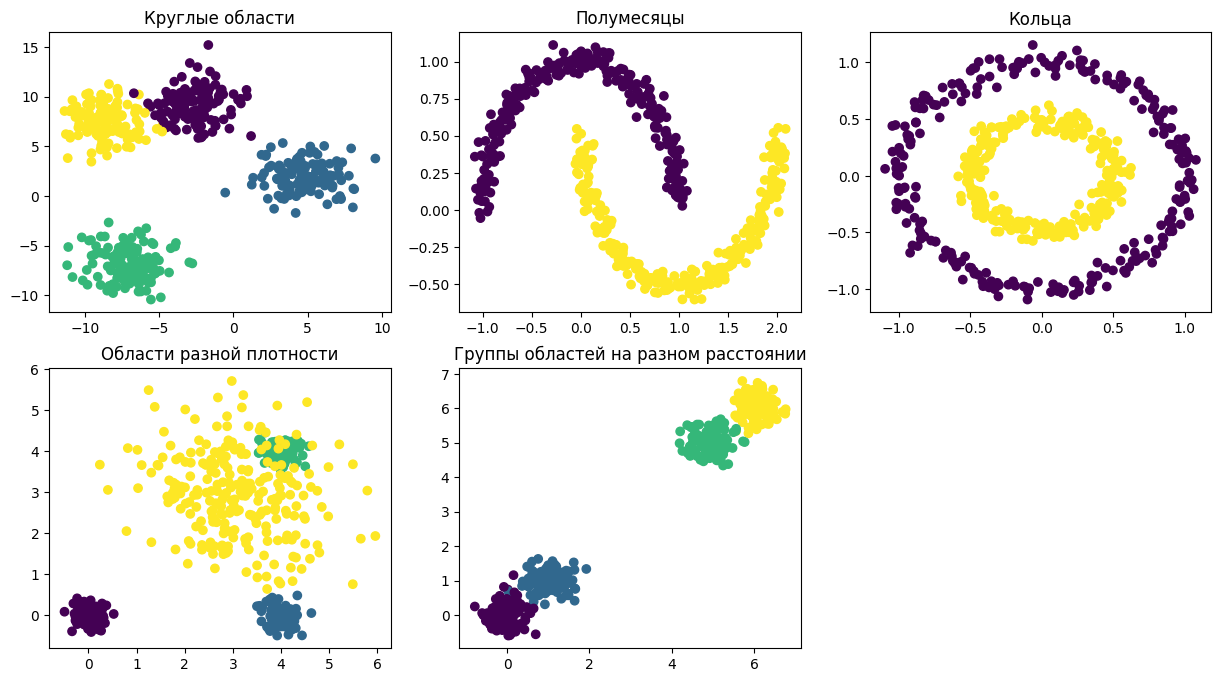

In [2]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

x_blob, y_blob = make_blobs(n_samples=500, centers=4, cluster_std=1.60, random_state=42)
ax[0, 0].scatter(x_blob[:, 0], x_blob[:, 1], c=y_blob)
ax[0, 0].set_title('Круглые области')

x_moons, y_moons = make_moons(n_samples=500, noise=0.05, random_state=42)
ax[0, 1].scatter(x_moons[:, 0], x_moons[:, 1], c=y_moons)
ax[0, 1].set_title('Полумесяцы')

x_circ, y_circ = make_circles(n_samples=500, noise=0.05, factor=0.5, random_state=42)
ax[0, 2].scatter(x_circ[:, 0], x_circ[:, 1], c=y_circ);
ax[0, 2].set_title('Кольца')

X1, y1 = make_blobs(n_samples=250, centers=[[0,0], [4, 0], [4, 4]], cluster_std=0.2)
X2, y2 = make_blobs(n_samples=250, centers=[[3,3]], cluster_std=1.0)

x_dense = np.vstack([X1, X2])
y_dense = np.concatenate([y1, y2 + 3])

ax[1, 0].scatter(x_dense[:, 0], x_dense[:, 1], c=y_dense)
ax[1, 0].set_title('Области разной плотности')

x_hier, y_hier = make_blobs(
    n_samples=500,
    centers=[[0,0], [1,1], [5,5], [6,6]],
    cluster_std=0.3,
    random_state=42
)
ax[1, 1].scatter(x_hier[:, 0], x_hier[:, 1], c=y_hier)
ax[1, 1].set_title('Группы областей на разном расстоянии')

ax[1, 2].remove();

А реальный датасет будет с новостями на разные тематики

In [3]:
df = pd.read_json("hf://datasets/SetFit/bbc-news/test.jsonl", lines=True)
df.head()

,text,label,label_text
0,carry on star patsy rowlands dies actress pats...,3,entertainment
1,sydney to host north v south game sydney will ...,2,sport
2,uk coal plunges into deeper loss shares in uk ...,1,business
3,blair joins school sailing trip the prime mini...,4,politics
4,bath faced with tindall ultimatum mike tindall...,2,sport


In [4]:
df.label_text.value_counts()

,count
label_text,
sport,236
business,224
tech,189
entertainment,176
politics,175


Его надо сначала векторизовать, используем для этого Tf-Idf

In [5]:
tfidf = TfidfVectorizer(stop_words=stops).fit(df.text)
vecs = tfidf.transform(df.text)
vecs.shape

(1000, 20759)

#### K-Means
Алгоритм:
1. Выбираем кол-во кластеров $k$ (гиперпараметр, нужно назначить руками)
2. Выбираем $k$ случайных объектов. Они будут центроидами будущих кластеров
3. Перебираем все объекты в данных, относим их к ближайшим центроидам
4. Для каждого получившегося кластера считаем среднее значение. Эти значения будут новыми кластерами
5. Повторяем шаги 3-4, пока центроиды не перестанут двигаться

homogeneity: 0.9711329457960169
completeness: 0.9711777833370984
v_measure: 0.9711553640490285


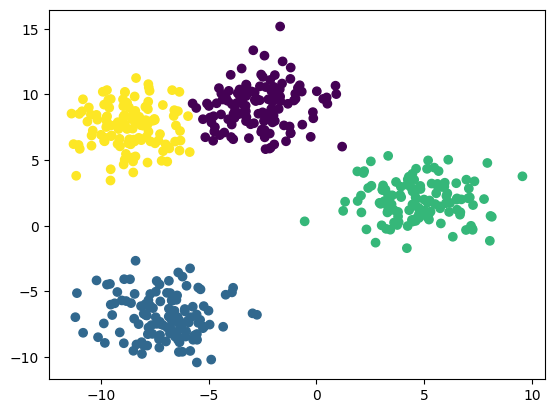

In [6]:
kmeans = KMeans(n_clusters=np.unique(y_blob).shape[0], random_state=0, n_init="auto")
kmeans.fit(x_blob)

preds = kmeans.labels_

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y_blob, preds)
print(f'homogeneity: {homogeneity}\ncompleteness: {completeness}\nv_measure: {v_measure}')

plt.scatter(x_blob[:, 0], x_blob[:, 1], c=preds);

Давайте соберем это в функцию, чтобы дальше можно было быстро рисовать

In [7]:
def eval_clustering(x, y, algorithm, algorithm_args=None, draw=True, ax=None):
    if algorithm_args is None:
        algorithm_args = {}

    algo = algorithm(**algorithm_args)
    algo.fit(x)

    preds = algo.labels_

    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, preds)
    name = f'h = {round(homogeneity, 4)}, c = {round(completeness, 4)}, v_m = {round(v_measure, 4)}'

    if draw:
        if ax:
            ax.scatter(x[:, 0], x[:, 1], c=preds)
            ax.set_title(name)
        else:
            plt.scatter(x[:, 0], x[:, 1], c=preds)
            plt.title(name)
    else:
        print(f'homogeneity: {homogeneity}\ncompleteness: {completeness}\nv_measure: {v_measure}')

    return algo, preds, homogeneity, completeness, v_measure

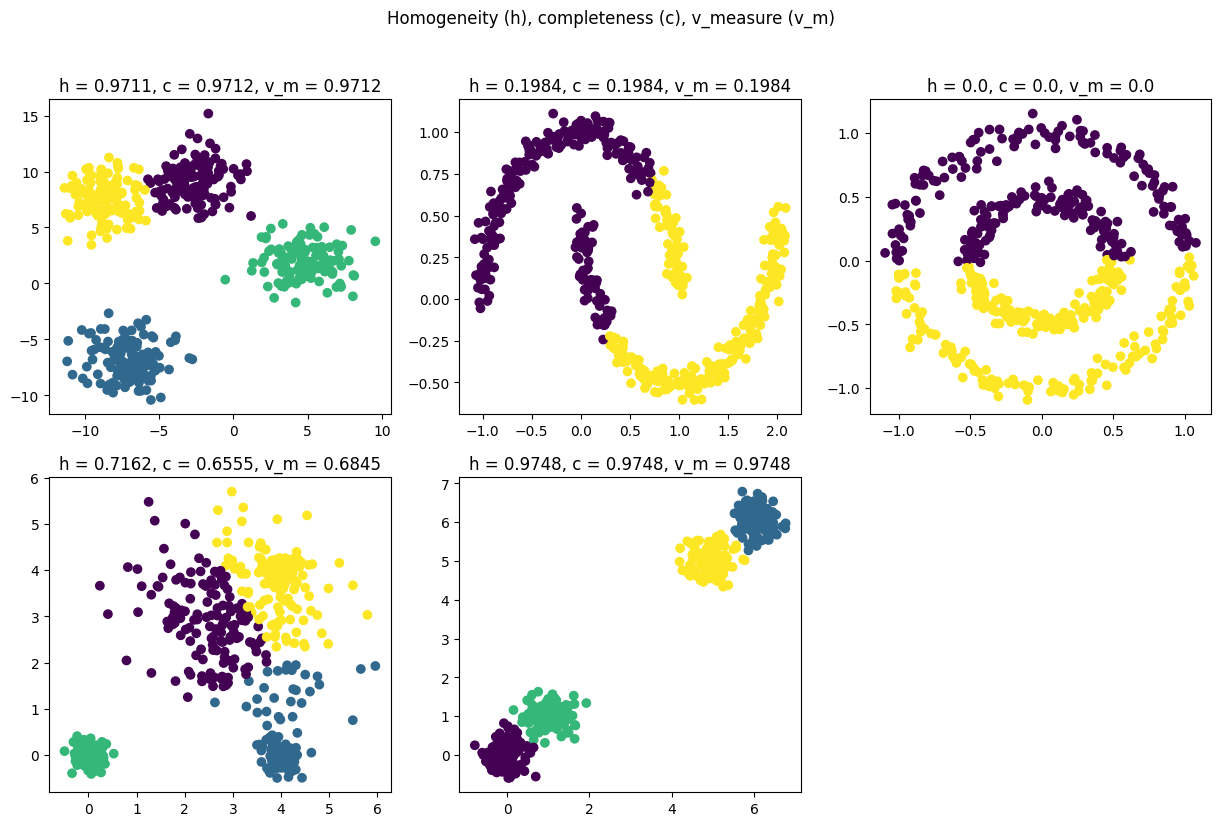

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(15, 9))
fig.suptitle('Homogeneity (h), completeness (c), v_measure (v_m)')

for i, (x, y) in enumerate(zip(
    [x_blob, x_moons, x_circ, x_dense, x_hier],
    [y_blob, y_moons, y_circ, y_dense, y_hier]
)):
    params = {
        'n_clusters': np.unique(y).shape[0],
        'random_state': 0,
        'n_init': "auto"
    }
    eval_clustering(x, y, KMeans, algorithm_args=params, draw=True, ax=ax[i // 3, i % 3])

ax[1, 2].remove();

Тексты мы пока рисовать не умеем, так что посмотрим просто на метрики

In [9]:
params = {
    'n_clusters': df.label_text.nunique(),
    'random_state': 0,
    'n_init': "auto"
}
eval_clustering(vecs, df.label_text, KMeans, algorithm_args=params, draw=False);

homogeneity: 0.655018757758912
completeness: 0.7264911533765783
v_measure: 0.6889061438820115


#### DBSCAN
Интуиция: если между точками можно проложить "плотную" дорожку, то они относятся к одному кластеру

Алгоритм (очень неформально):
1. Берем случайную точку. Если рядом меньше нужного кол-ва точек, то считаем, что эта точка может быть шумом и идем к следующей. В итоге нам нужна точка, у которой достаточное кол-во соседей
2. Для такой точки создаем группу, в которой она пока будет одна
3. Обходим всех соседей точки. Если точка есть в списке возможного шума, то считаем, что это край группы. Если рядом есть другие "популярные" точки, то считаем их частью группы и перебираем и их соседей тоже
4. Алгоритм заканчивается, когда мы тем или иным способом посмотрели на все точки
5. В списке шума остался шум, остальное разделилось на кластеры

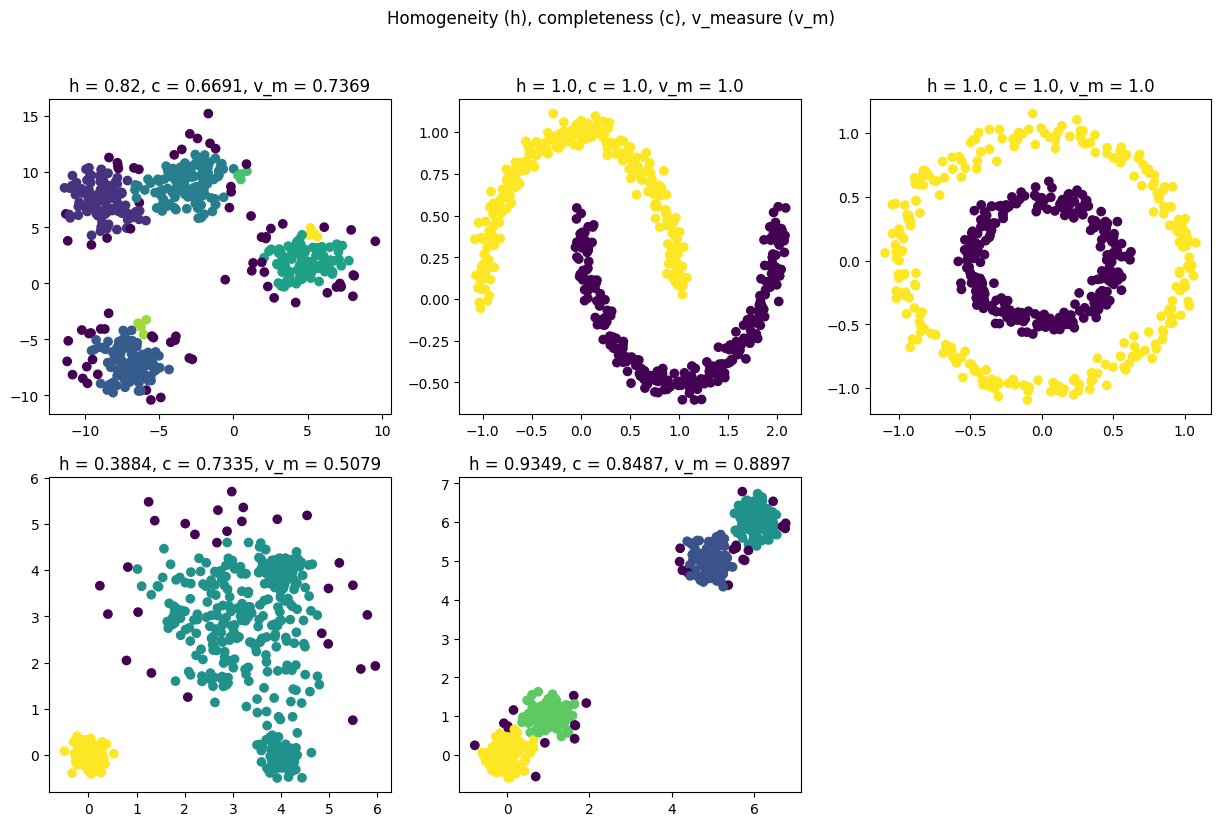

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(15, 9))
fig.suptitle('Homogeneity (h), completeness (c), v_measure (v_m)')

# eps - макс. расстояние между двумя точками, при котором одна из них должна
# рассматриваться как находящаяся по соседству с другой.
eps = [0.75, 0.2, 0.2, 0.4, 0.2]

for i, (x, y) in enumerate(zip(
    [x_blob, x_moons, x_circ, x_dense, x_hier],
    [y_blob, y_moons, y_circ, y_dense, y_hier]
)):
    params = {
        'eps': eps[i],
        'min_samples': 5
    }
    eval_clustering(x, y, DBSCAN, algorithm_args=params, draw=True, ax=ax[i // 3, i % 3])

ax[1, 2].remove();

И для текстов (очень плохо)

In [11]:
params = {
        'eps': 0.01,
        'min_samples': 1
    }
eval_clustering(vecs, df.label_text, DBSCAN, algorithm_args=params, draw=False);

homogeneity: 1.0
completeness: 0.23306410836656008
v_measure: 0.37802431647337476


#### AgglomerativeClustering
Интуиция: объединяем кластеры, пока можем это делать

Алгоритм:
1. Каждый объект представляет собой кластер
2. Считаем попарную близость для всех кластеров
3. Объединяем два с наибольшим значением
4. Повторяем 2-3, пока не достигнут критерий остановки (чаще всего кол-во кластеров)

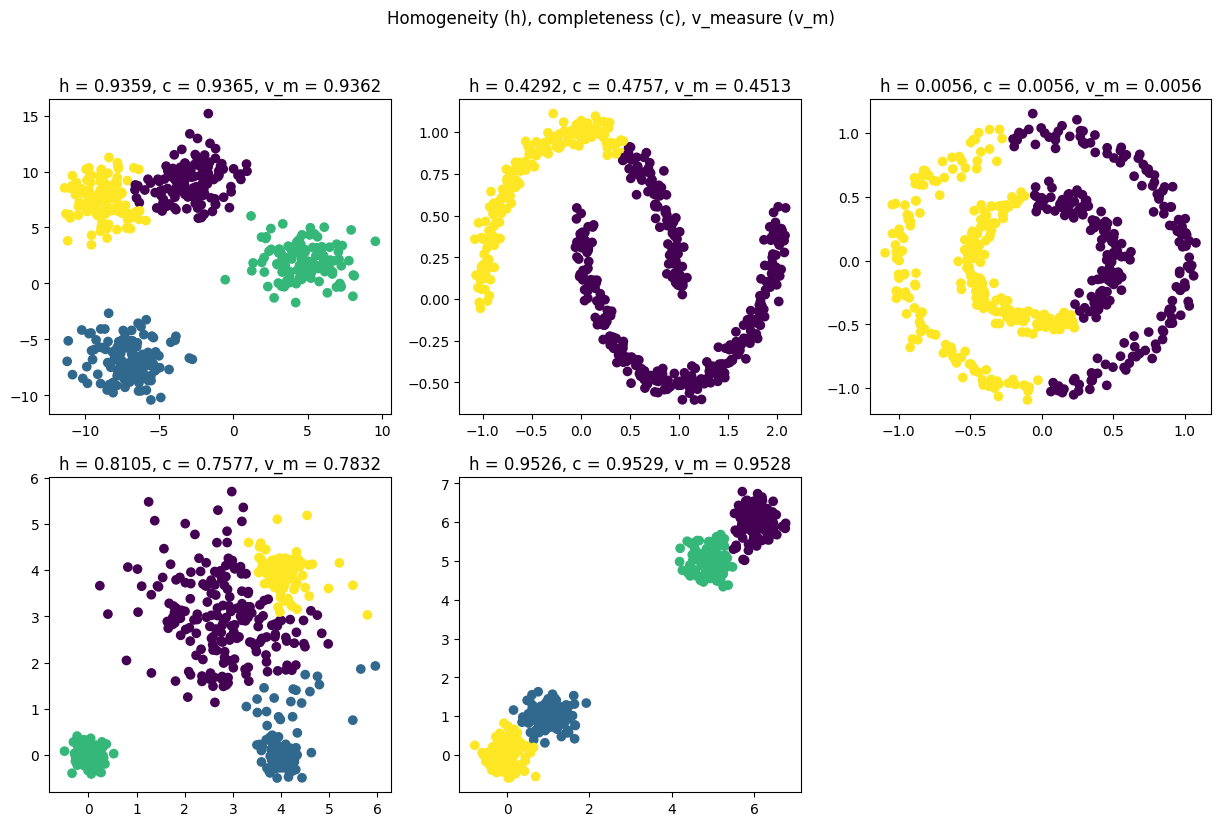

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(15, 9))
fig.suptitle('Homogeneity (h), completeness (c), v_measure (v_m)')


# n_clusters - количество кластеров, которые нужно найти
# должно быть None, если значение distance_threshold не None


for i, (x, y) in enumerate(zip(
    [x_blob, x_moons, x_circ, x_dense, x_hier],
    [y_blob, y_moons, y_circ, y_dense, y_hier]
)):
    params = {
        'n_clusters': np.unique(y).shape[0]
    }
    eval_clustering(x, y, AgglomerativeClustering, algorithm_args=params, draw=True, ax=ax[i // 3, i % 3])

ax[1, 2].remove();

А теперь давайте посмотрим, в чем же тут иерархия

In [13]:
params = {
    'n_clusters': np.unique(y_hier).shape[0],
    'compute_distances': True
}
agl, preds, _, _, _ = eval_clustering(x_hier, y_hier, AgglomerativeClustering,
                                       algorithm_args=params, draw=False)

homogeneity: 0.9526194741739218
completeness: 0.9528944947725679
v_measure: 0.9527569646265445


In [14]:
# Просто красиво рисует картинки, не вникайте

def plot_hierarchical_clustering_steps(model, X, max_levels=5):
    n_samples = len(X)

    counts = np.zeros(model.children_.shape[0])
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    n_clusters_range = [2, 3, 4, 5, 6, 8, 10, 15, 20]
    n_clusters_range = [n for n in n_clusters_range if n < n_samples and n > 1]
    n_clusters_range = n_clusters_range[:max_levels]

    n_plots = len(n_clusters_range) + 1
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten() if n_plots > 1 else [axes]

    ax = axes[0]
    dendrogram(linkage_matrix, ax=ax, truncate_mode='level', p=4)
    ax.set_title('Дендрограмма')
    ax.set_ylabel('Расстояние')

    for i, n_clusters in enumerate(n_clusters_range, start=1):
        if i >= len(axes):
            break

        ax = axes[i]

        clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

        scatter = ax.scatter(X[:, 0], X[:, 1], c=clusters, cmap='tab20',
                           s=50, alpha=0.7, edgecolors='black', linewidth=0.5)

        if n_samples < 30:
            Z = linkage_matrix
            for j in range(len(Z)):
                if Z[j, 2] < np.percentile(Z[:, 2], 50):
                    idx1, idx2 = int(Z[j, 0]), int(Z[j, 1])

                    if idx1 < n_samples:
                        x1, y1 = X[idx1]
                    else:
                        members1 = np.where(clusters == clusters[idx1 - n_samples + 1])[0]
                        x1, y1 = np.mean(X[members1], axis=0)

                    if idx2 < n_samples:
                        x2, y2 = X[idx2]
                    else:
                        members2 = np.where(clusters == clusters[idx2 - n_samples + 1])[0]
                        x2, y2 = np.mean(X[members2], axis=0)

                    ax.plot([x1, x2], [y1, y2], 'gray', alpha=0.3, linewidth=0.5)

        ax.set_title(f'{n_clusters} кластеров')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.grid(True, alpha=0.3)

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    return fig

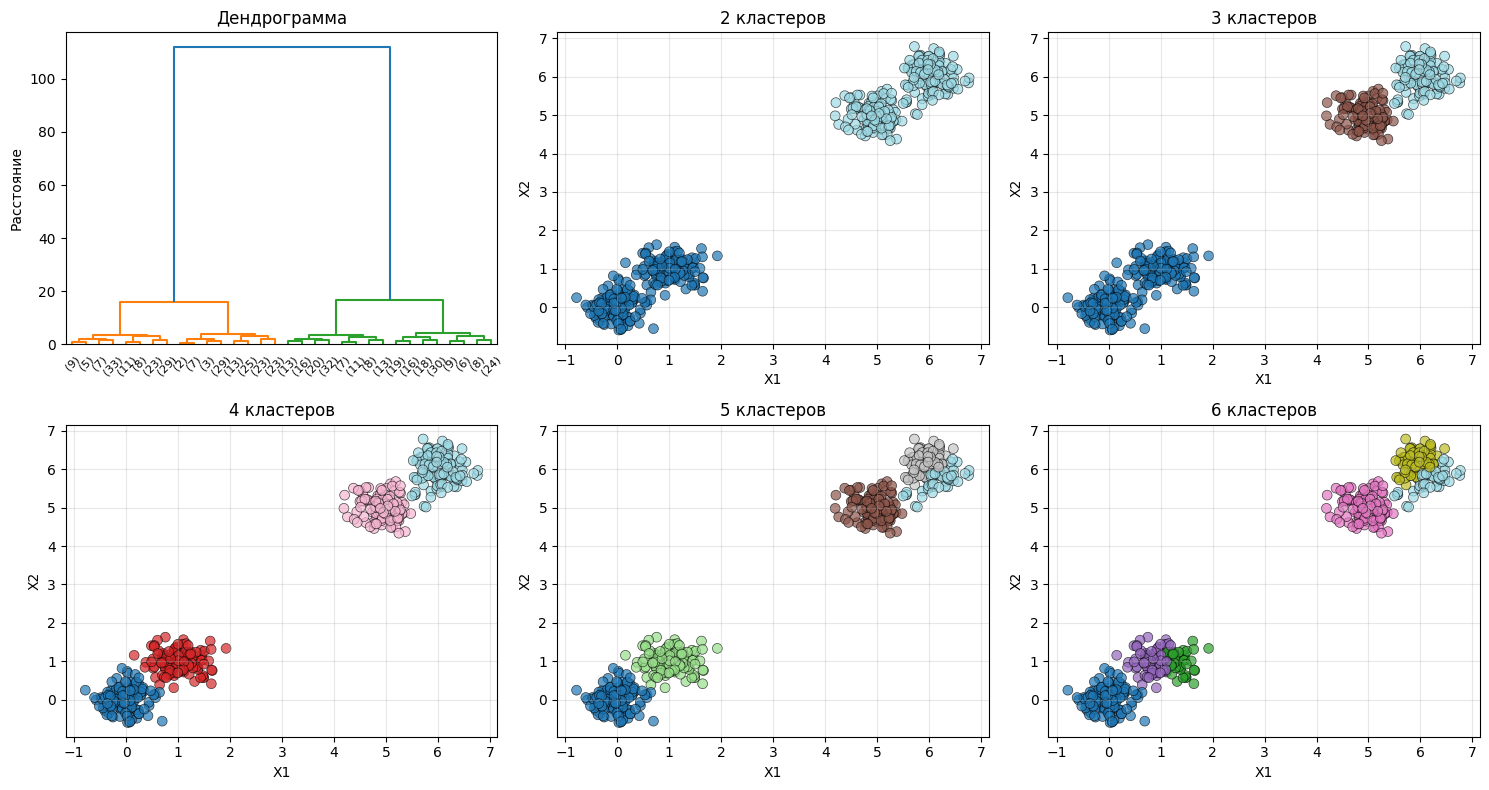

In [15]:
plot_hierarchical_clustering_steps(agl, x_hier, max_levels=5)
plt.show()

И для текстов (неплохо, но хуже, чем KMeans)

In [16]:
params = {
        'n_clusters': df.label_text.nunique()
    }
eval_clustering(vecs.toarray(), df.label_text, AgglomerativeClustering,
                algorithm_args=params, draw=False);

homogeneity: 0.44805600510428073
completeness: 0.6549203859856019
v_measure: 0.5320893795670547
